# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb





%matplotlib inline

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# Load in the data, specifying datatypes for columns 18 and 19, which have mixtures of datatypes, to speed up import
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})

# Create backup copies to avoid having to reimport
azdias_copy = azdias.copy()
customers_copy = customers.copy()

In [5]:
# Load in information on the features
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [6]:
# Overview of customer data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
# Overview of azdias data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
# Overview of feature summary
feature_summary.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
# Find names of problematic 18th and 19th columns
customers.columns[18], customers.columns[19]
# According to the schema, these columns are the New German CAMEO Typology established together with Call Credit in late 2015

('CAMEO_DEUG_2015', 'CAMEO_INTL_2015')

In [10]:
# Change columns 18 and 19 to type float
customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'], errors='coerce')
customers['CAMEO_INTL_2015'] = pd.to_numeric(customers['CAMEO_INTL_2015'], errors='coerce')
azdias['CAMEO_DEUG_2015'] = pd.to_numeric(azdias['CAMEO_DEUG_2015'], errors='coerce')
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'], errors='coerce')

In [11]:
# Explore dimensions of datasets
customers.shape, azdias.shape, feature_summary.shape

((191652, 369), (891221, 366), (85, 4))

I have detailed information about 85 columns thanks to the feature summary datafile. The customers and azdias datasets have 284 and 281 columns respectively. 
For similicity and to reduce processing power, I will cut these datasets down to just the columns for which I have detailed information

In [12]:
# Create list of columns for which I have detailed information
cols = list(feature_summary['attribute'])
cols.append('LNR')
# Add additional customer columns to the list
cust_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
cust_cols = cols + cust_cols

In [13]:
# Cut down customer and azdias datasets to just columns found in feature_summary
customers = customers[cust_cols]
azdias = azdias[cols]

In [14]:
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(10)

KK_KUNDENTYP    58.41
KBA05_ANTG3     29.21
KBA05_BAUMAX    29.21
KBA05_GBZ       29.21
KBA05_ANTG2     29.21
KBA05_ANTG1     29.21
MOBI_REGIO      29.21
KBA05_ANTG4     29.21
REGIOTYP        28.31
KKK             28.31
dtype: float64

In [15]:
# The feature_summary file contains some information on how missing fields are represented in different columns
feature_summary['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,XX]      1
[-1,X]       1
[XX]         1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [16]:
# Find columns with different missing value coing
neg_1_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('-1')]['attribute']
zero_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('0')]['attribute']
nine_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('9')]['attribute']
xx_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('XX')]['attribute']
x_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('X')]['attribute']

In [17]:
# Replace -1 with NA for specified columns
customers[neg_1_cols] = customers.loc[:,neg_1_cols].replace({-1:np.nan})
azdias[neg_1_cols] = azdias.loc[:,neg_1_cols].replace({-1:np.nan})

In [18]:
# Replace 0 with NA for specified columns
customers[zero_cols] = customers.loc[:,zero_cols].replace({0:np.nan})
azdias[zero_cols] = azdias.loc[:,zero_cols].replace({0:np.nan})

In [19]:
# Replace 9 with NA for specified columns
customers[nine_cols] = customers.loc[:,nine_cols].replace({9:np.nan})
azdias[nine_cols] = azdias.loc[:,nine_cols].replace({9:np.nan})

In [20]:
# Replace XX with NA for specified columns
customers[xx_cols] = customers.loc[:,xx_cols].replace({'XX':np.nan})
azdias[xx_cols] = azdias.loc[:,xx_cols].replace({'XX':np.nan})

In [21]:
# Replace X with NA for specified columns
customers[x_cols] = customers.loc[:,x_cols].replace({'X':np.nan})
azdias[x_cols] = azdias.loc[:,x_cols].replace({'X':np.nan})

Text(0.5,0,'Columns in dataset')

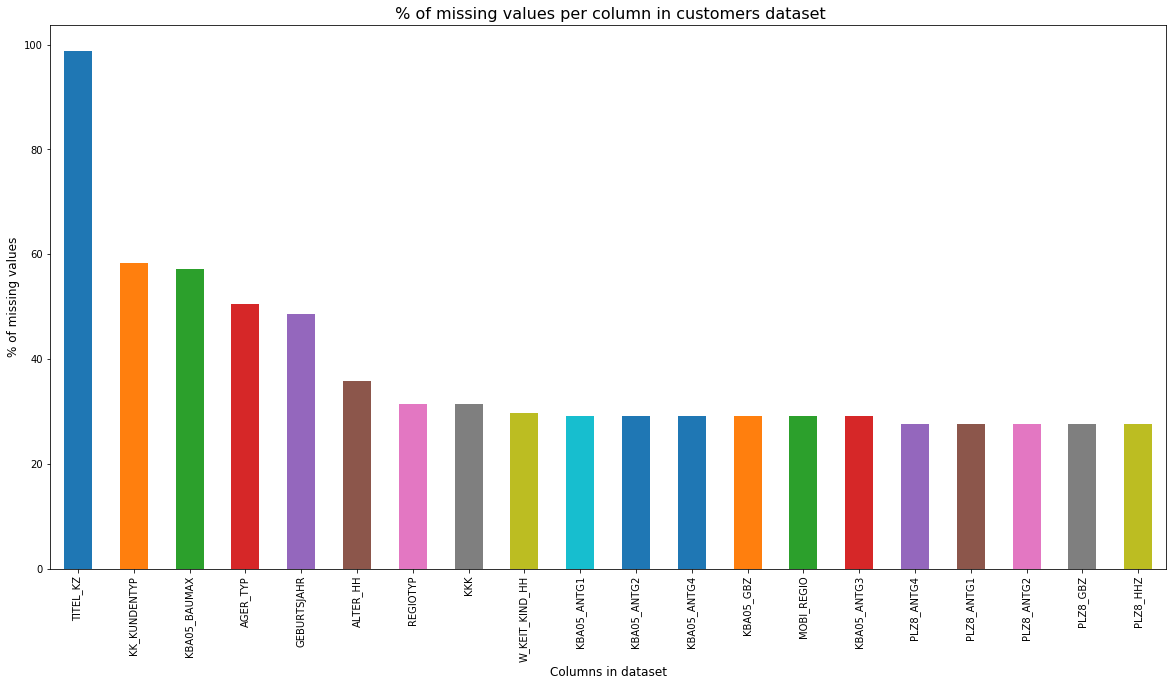

In [22]:
# Find and visualise columns with most missing data in customers dataset
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in customers dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('Columns in dataset', fontdict={'fontsize': 12})

Text(0.5,0,'columns in dataset')

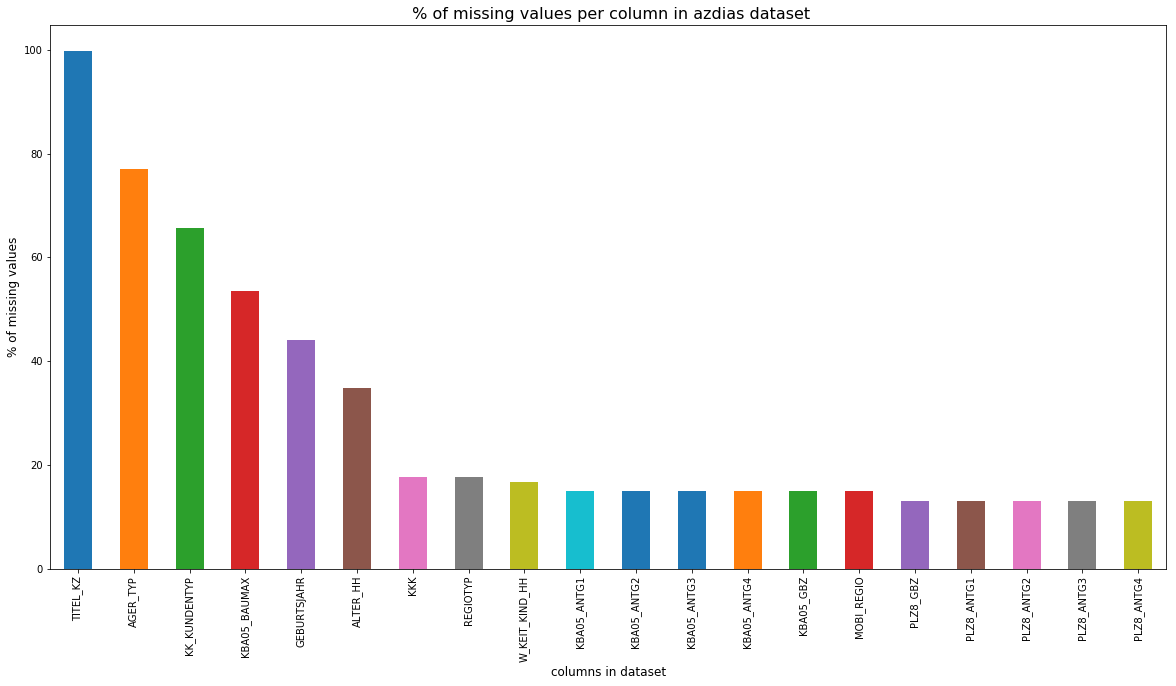

In [23]:
# Find columns with most missing data in azdias dataset
round(azdias.isnull().sum(axis = 0)/azdias.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in azdias dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('columns in dataset', fontdict={'fontsize': 12})

In [24]:
# Remove columns with a high proportion of missing data
# Columns which have >50% missing data in datasets
empty_cols_cust = list(customers.columns[customers.isnull().sum(axis = 0)/customers.shape[0]*100 > 50])
empty_cols_az = list(azdias.columns[azdias.isnull().sum(axis = 0)/azdias.shape[0]*100 > 50])

# Combine list of columns
empty_cols = set(empty_cols_cust + empty_cols_az)

# Remove columns from datasets
customers = customers.drop(columns = empty_cols, axis=1)
azdias = azdias.drop(columns = empty_cols, axis=1)
# Remove thes rows from feature_summary dataset
feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute'].isin(empty_cols)].index, axis=0)

In [25]:
# Remove rows with a high proportion of missing data (>80%)
empty_rows = customers[customers.isnull().sum(axis = 1)/customers.shape[1]*100 > 80].index
customers = customers.drop(empty_rows, axis=0)

empty_rows = azdias[azdias.isnull().sum(axis = 1)/azdias.shape[1]*100 > 80].index
azdias = azdias.drop(empty_rows, axis=0)

Text(0.5,0,'Field datatypes')

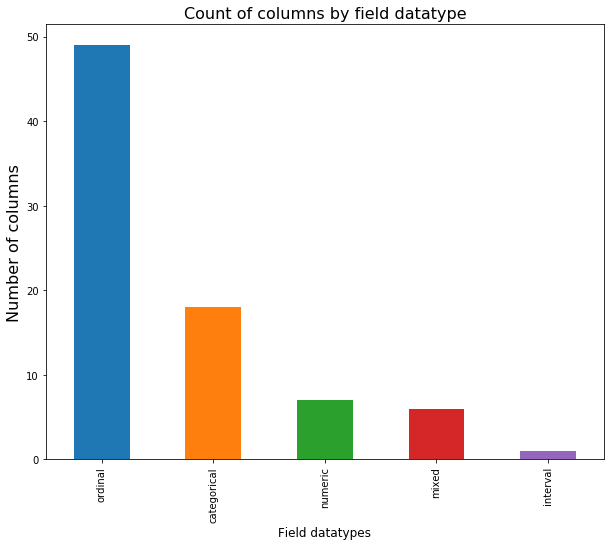

In [26]:
# Explore datatypes so that I know the best imputation method to use
# There are 5 types of data in the dataset 
feature_summary['type'].value_counts().plot(kind = 'bar', figsize=(10,8))
plt.title("Count of columns by field datatype", fontdict={'fontsize': 16})
plt.ylabel('Number of columns', fontdict={'fontsize': 16})
plt.xlabel('Field datatypes', fontdict={'fontsize': 12})

In [27]:
# 49 columns are ordinal
ordinal_cols = list(feature_summary[feature_summary['type'] == 'ordinal']['attribute'])
customers[ordinal_cols].head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,1.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0
1,4.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,7.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0
3,4.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,3.0,6.0,...,6.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,7.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0


In [28]:
# 18 columns are categorical
categorical_cols = list(feature_summary[feature_summary['type'] == 'categorical']['attribute'])
customers[categorical_cols].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1.0,5.0,2.0,4.0,1,2.0,2.0,10.0,5.0,1.0,3.0,0.0,1.0,3.0,1.0,W,1.0,1A
1,1.0,NaN,2.0,NaN,0,NaN,NaN,NaN,NaN,1.0,3.0,0.0,1.0,3.0,NaN,NaN,NaN,NaN
2,2.0,2.0,2.0,3.0,1,1.0,1.0,10.0,5.0,1.0,1.0,0.0,2.0,3.0,8.0,W,5.0,5D
3,1.0,2.0,6.0,10.0,0,NaN,NaN,9.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,W,4.0,4C
4,1.0,6.0,2.0,2.0,0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,3.0,W,7.0,7B


In [29]:
# 7 of the columns have numeric data types e.g Year of birth, number of cars, number of adults in household
numeric_cols = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
customers[numeric_cols].head()

,GEBURTSJAHR,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
0,NaN,2.0,0.0,1.0,0.0,1992.0,1201.0
1,NaN,3.0,0.0,NaN,NaN,NaN,NaN
2,NaN,1.0,0.0,1.0,0.0,1992.0,433.0
3,NaN,0.0,0.0,NaN,NaN,1992.0,755.0
4,1960.0,4.0,0.0,7.0,0.0,1992.0,513.0


In [30]:
# 6 columns have mixed data types e.g. lifestage (family, income etc)
mixed_cols = list(feature_summary[feature_summary['type'] == 'mixed']['attribute'])
customers[mixed_cols].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
0,20.0,5.0,4.0,7.0,13.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN
2,13.0,3.0,4.0,2.0,34.0,3.0
3,NaN,NaN,1.0,7.0,24.0,1.0
4,31.0,10.0,8.0,3.0,41.0,2.0


In [31]:
# 1 column is type interval e.g. Interval of main age within household
interval_cols = list(feature_summary[feature_summary['type'] == 'interval']['attribute'])
customers[interval_cols].head()

,ALTER_HH
0,10.0
1,11.0
2,6.0
3,8.0
4,20.0


In [32]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

In [33]:
# Fill numeric fields with mean
num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])

customers = fill_mean(customers, num_vars)
azdias = fill_mean(azdias, num_vars)

In [34]:
# Create function which fills missing values with mode 
fill_mode = lambda col: col.fillna(col.mode()[0])
# Apply to all non-numerical columns in customers dataset
customers = customers.apply(fill_mode, axis=0)
# Apply to all non-numerical columns in azdias dataset
azdias = azdias.apply(fill_mode, axis=0)

One obervation is that column CAMEO_DEU_2015 appears to be a copy of CAMEO_DEUG_2015 with an additional letter field.

In [35]:
# Extract letter from CAMEO_DEU_2015 into new column
customers['CAMEO_DEU_2015_let'] = customers['CAMEO_DEU_2015'].str[1]
azdias['CAMEO_DEU_2015_let'] = azdias['CAMEO_DEU_2015'].str[1]

In [36]:
# Verify that remaining number from CAMEO_DEU_2015 is a duplicate of CAMEO_DEUG_2015
cameo_data = customers[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']]
cameo_data['CAMEO_DEU_2015_num'] = cameo_data['CAMEO_DEU_2015'].str[0]
cameo_data['CAMEO_DEU_2015_num'] = pd.to_numeric(cameo_data['CAMEO_DEU_2015_num'], errors='coerce')
cameo_data['diff'] = cameo_data['CAMEO_DEU_2015_num'] - cameo_data['CAMEO_DEUG_2015']
cameo_data['diff'].sum()

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

0.0

In [37]:
# As the remaining number from CAMEO_DEU_2015 is a duplicate of CAMEO_DEUG_2015, remove original CAMEO_DEUG_2015 column
customers_clean = customers.drop(columns = 'CAMEO_DEU_2015', axis=1)
azdias_clean = azdias.drop(columns = 'CAMEO_DEU_2015', axis=1)
feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute']== 'CAMEO_DEU_2015'].index, axis=0)

Text(0.5,0,'Datatypes')

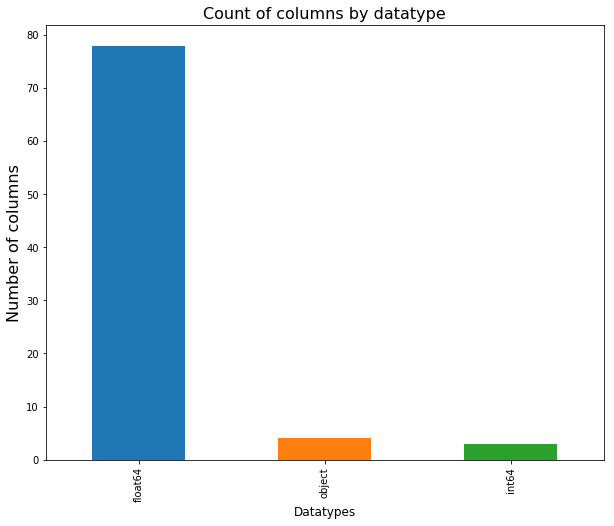

In [38]:
# Evaluate data types
customers_clean.dtypes.value_counts().plot(kind = 'bar', figsize=(10,8))
plt.title("Count of columns by datatype", fontdict={'fontsize': 16})
plt.ylabel('Number of columns', fontdict={'fontsize': 16})
plt.xlabel('Datatypes', fontdict={'fontsize': 12})

In [39]:
# Identify columns with object datatype
obj_cols = customers_clean.columns[customers_clean.dtypes == 'object']
customers_clean[obj_cols].head()

,OST_WEST_KZ,CUSTOMER_GROUP,PRODUCT_GROUP,CAMEO_DEU_2015_let
0,W,MULTI_BUYER,COSMETIC_AND_FOOD,A
1,W,SINGLE_BUYER,FOOD,D
2,W,MULTI_BUYER,COSMETIC_AND_FOOD,D
3,W,MULTI_BUYER,COSMETIC,C
4,W,MULTI_BUYER,FOOD,B


In [40]:
# Encode object fields
le = preprocessing.LabelEncoder()
customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'CAMEO_DEU_2015_let', 'OST_WEST_KZ']] = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'CAMEO_DEU_2015_let', 'OST_WEST_KZ']].apply(le.fit_transform)
azdias_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']] = azdias_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']].apply(le.fit_transform)


In [41]:
# Check number of missing values in customers dataset
round(customers_clean.isnull().sum(axis = 0)/customers_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

CAMEO_DEU_2015_let    0.0
SEMIO_KULT            0.0
RETOURTYP_BK_S        0.0
SEMIO_SOZ             0.0
SEMIO_FAM             0.0
SEMIO_REL             0.0
SEMIO_MAT             0.0
SEMIO_VERT            0.0
SEMIO_LUST            0.0
SEMIO_ERL             0.0
dtype: float64

In [42]:
# Check number of missing values in azdias dataset
round(azdias_clean.isnull().sum(axis = 0)/azdias_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

CAMEO_DEU_2015_let    0.0
NATIONALITAET_KZ      0.0
RETOURTYP_BK_S        0.0
SEMIO_SOZ             0.0
SEMIO_FAM             0.0
SEMIO_REL             0.0
SEMIO_MAT             0.0
SEMIO_VERT            0.0
SEMIO_LUST            0.0
SEMIO_ERL             0.0
dtype: float64

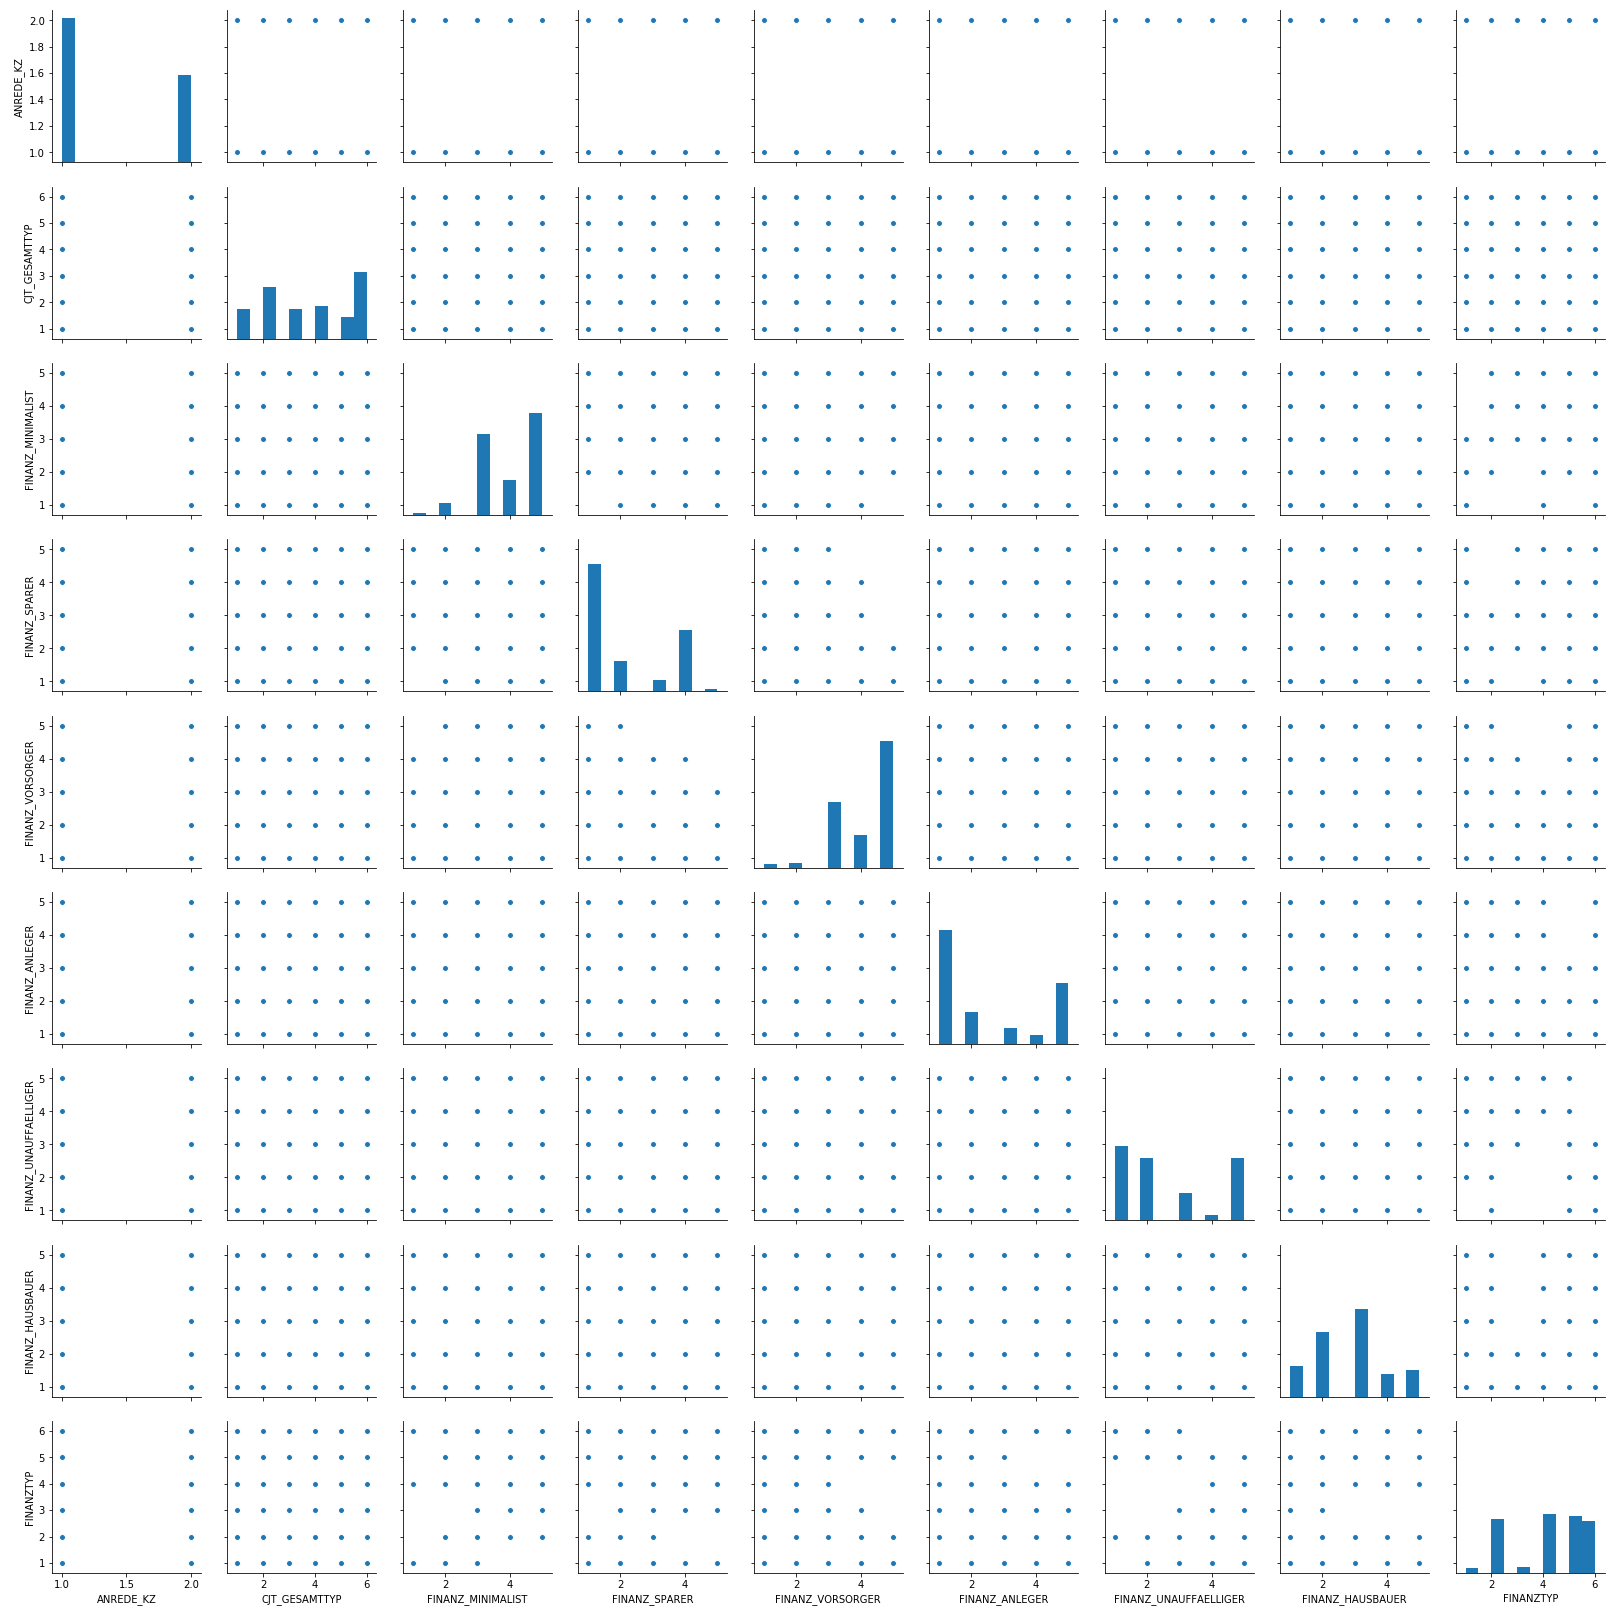

In [43]:
# Look at distribution of a subset of columns based on code on https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
customers_subset = customers_clean.iloc[: ,1:10]
sns.pairplot(customers_subset)

In [44]:
# Even when looking at the first 10 columns many are not normally distributed

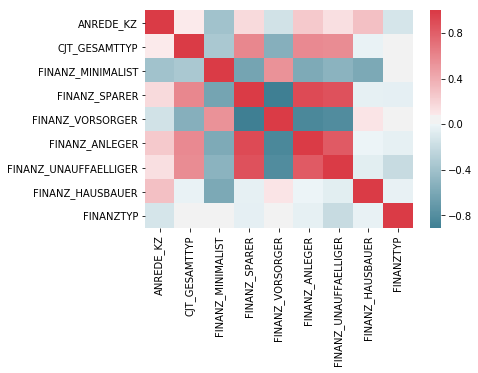

In [45]:
# There are a lot of columns in the dataset and it is likely that a lot will correlate
# Create visualisation of correlations between columns based on code on https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
corr = customers_subset.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [46]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

# Create function which fills missing values with mode 
fill_mode = lambda col: col.fillna(col.mode()[0])

# Put cleaning steps in function
def clean_data(df, feature_summary):
    '''
     INPUT:
     df - dataframe of input data
     feature_summary - summary of data fields including data types and how missing values are represented
     OUTPUT:
     df_clean - dataframe of data ready for modeling
     
     Sorts columns with incorrect datatypes
     Removes columns which are not in features_summary df
     Replaces values which represent unknowns with NAs
     Removes columns and rows with a high proportion of unknown data
     Fills missing numeric values with mean
     Fills missing non-numeric values with mode
     Extract letter field from CAMEO_DEU_2015 and removes original column
     
     '''
    
    # Sort columns with incorrect datatypes
    for col in (['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Create list of columns for which I have detailed information
    cols = list(feature_summary['attribute'])
    # Add additional columns to the list
    add_cols = ['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RESPONSE']
    all_cols = cols + add_cols
    df = df.loc[:,df.columns.isin(all_cols)]
    
    # Replace values which represent unknown values with na
    for value in [-1, 0, 9, 'XX', 'X']:
        cols = feature_summary[feature_summary['missing_or_unknown'].str.contains(str(value))]['attribute']
        df[cols] = df.loc[:,cols].replace({value:np.nan})
    
    # Remove columns with a high proportion of missing data
    # Columns which have >50% missing data in datasets
    empty_cols = list(df.columns[df.isnull().sum(axis = 0)/df.shape[0]*100 > 50])
    # Remove columns from datasets
    df = df.drop(columns = empty_cols, axis=1)
    # Remove thes rows from feature_summary dataset
    feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute'].isin(empty_cols)].index, axis=0)
    
    # Remove rows with a high proportion of missing data
    empty_rows = df[df.isnull().sum(axis = 1)/df.shape[1]*100 > 80].index
    df = df.drop(empty_rows, axis=0)
     
     # Fill missing numeric fields with mean
    num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
    df = fill_mean(df, num_vars)
    
    # Fill missing non-numeric fields with mode                                           
    df = df.apply(fill_mode, axis=0)   
    #df = df.fillna(-1)
    
    # Extract letter field from CAMEO_DEU_2015 and remove original, which is a duplicate of CAMEO_DEUG_2015
    df['CAMEO_DEU_2015_let'] = df['CAMEO_DEU_2015'].str[1]
    df_clean = df.drop(columns = 'CAMEO_DEU_2015', axis=1)
    feature_summary_updated = feature_summary.drop(feature_summary[feature_summary['attribute']== 'CAMEO_DEU_2015'].index, axis=0)
    
                                                                                                                                                         
    return df_clean , feature_summary_updated

In [47]:
# # Check function is working
# Import data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [48]:
# Apply function to datasets
customers_clean, fs = clean_data(customers, feature_summary)
azdias_clean, fs = clean_data(azdias, feature_summary)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [49]:
round(customers_clean.isnull().sum(axis = 0)/customers_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

CAMEO_DEU_2015_let    0.0
KBA05_ANTG4           0.0
GFK_URLAUBERTYP       0.0
GREEN_AVANTGARDE      0.0
HEALTH_TYP            0.0
HH_EINKOMMEN_SCORE    0.0
INNENSTADT            0.0
KBA05_ANTG1           0.0
KBA05_ANTG2           0.0
KBA05_ANTG3           0.0
dtype: float64

In [51]:
round(azdias_clean.isnull().sum(axis = 0)/azdias_clean.shape[0]*100,2).sort_values(ascending = False).head(10)
# There are no longer any missing values in the datasets suggesting the function is working

CAMEO_DEU_2015_let    0.0
GEBAEUDETYP_RASTER    0.0
GFK_URLAUBERTYP       0.0
GREEN_AVANTGARDE      0.0
HEALTH_TYP            0.0
HH_EINKOMMEN_SCORE    0.0
INNENSTADT            0.0
KBA05_ANTG1           0.0
KBA05_ANTG2           0.0
KBA05_ANTG3           0.0
dtype: float64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
# # Check function is working
# Import data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
# Apply function to datasets
customers_clean, fs = clean_data(customers, feature_summary)
azdias_clean, fs = clean_data(azdias, feature_summary)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [6]:
# Remove numeric fields ahead of k-modes segmentation
num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
customers_clean = customers_clean.drop(num_vars, axis = 1)
azdias_clean = azdias_clean.drop(num_vars, axis = 1)

In [7]:
# Remove columns which aren't present in both dataframes ahead of segmentation
uncommon_cols = set(customers_clean.columns).symmetric_difference(set(azdias_clean.columns))
customers_clean = customers_clean.drop(columns = uncommon_cols, axis=1, errors = 'ignore')
azdias_clean = azdias_clean.drop(columns = uncommon_cols, axis=1, errors = 'ignore')

In [8]:
# Label encode object fields
le = preprocessing.LabelEncoder()
obj_cols = customers_clean.columns[customers_clean.dtypes == 'object']
customers_clean[obj_cols] = customers_clean[obj_cols].apply(le.fit_transform)
azdias_clean[obj_cols] = azdias_clean[obj_cols].apply(le.fit_transform)

In [9]:
customers_clean.shape

(191652, 75)

In [10]:
azdias_clean.shape
# Both datasets have the same number of rows and so are ready for segmenatation steps

(891221, 75)

In [11]:
# Remove ID column named LNR
customers_clean = customers_clean.drop(columns = ['LNR'], axis=1)
azdias_clean = azdias_clean.drop(columns = ['LNR'], axis=1)

In [12]:
# Creating a copy
customers_clean_copy = customers_clean.copy()
azdias_clean_copy = azdias_clean.copy()

### Kmodes on clean dataset

In [15]:
# Apply kmodes
kmodes = KModes(n_clusters=2, init = "Cao", verbose=1)
kmodes.fit_predict(customers_clean)
cost = [("Clean data", kmodes.cost_)]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 24483, cost: 6194198.0
Run 1, iteration: 2/100, moves: 4959, cost: 6194198.0


### Kmodes on scaled dataset

In [16]:
c_2 = customers_clean_copy

# Declare and fit scaler to 
scaler = StandardScaler()
scaler.fit(c_2)
c_2_scaled_features = scaler.transform(c_2)
c_2_scaled = pd.DataFrame(c_2_scaled_features, columns=c_2.columns)

# Apply kmodes
kmodes_2 = KModes(n_clusters=2, random_state=20, verbose=1, init = "Cao")
fitClusters_cao_2 = kmodes_2.fit_predict(c_2_scaled)
cost.append(("Scaled", kmodes_2.cost_))

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 24483, cost: 6194198.0
Run 1, iteration: 2/100, moves: 4959, cost: 6194198.0


### Kmodes on reduced dataset

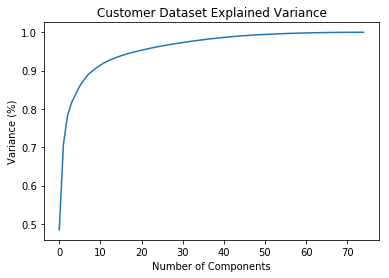

In [36]:
c_3 = customers_clean_copy

#Determine the number of components to use using link: https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
#Fitting the PCA algorithm with our Data
pca_3 = PCA().fit(c_3)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Customer Dataset Explained Variance')
plt.show()
# Plot suggests 20 components descripe 90% of the data



In [37]:
# Reduce customers dataset (minus clusters) to 20 components using PCA
pca_3 = PCA(n_components=20)
c_3_components = pca_3.fit_transform(c_3)

#Apply kmodes
kmodes_3 = KModes(n_clusters=2, init = "Cao", verbose=1)
kmodes_3.fit_predict(c_3_components)
cost.append(("Reduced", kmodes_3.cost_))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3445940.0


### Kmodes on scaled, reduced data

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


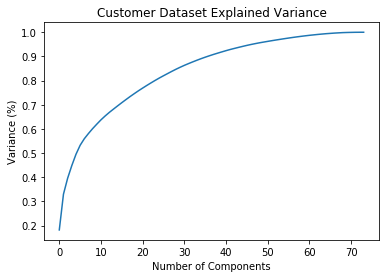

In [52]:
c_4 = customers_clean_copy

# Declare and fit scaler to 
scaler = StandardScaler()
scaler.fit(c_4)
c_4_scaled_features = scaler.transform(c_2)
c_4_scaled = pd.DataFrame(c_2_scaled_features, columns=c_4.columns)

# Determine the number of components to use using link: https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
# Fitting the PCA algorithm with our Data
pca_4 = PCA().fit(c_4_scaled)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_4.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Customer Dataset Explained Variance')
plt.show()
# Plot suggests 50 components descripe 90% of the data

In [53]:
# Reduce customers dataset (minus clusters) to 20 components using PCA
pca_4 = PCA(n_components=50)
c_4_components = pca_4.fit_transform(c_4_scaled)

# Apply kmodes
kmodes_4 = KModes(n_clusters=2, init = "Cao", verbose=1)
kmodes_4.fit_predict(c_4_components)
cost.append(("Scaled and Reduced", kmodes_4.cost_))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 8615280.0


In [54]:
cost

[('Clean data', 6194198.0),
 ('Scaled', 6194198.0),
 ('Reduced', 3445940.0),
 ('Scaled and Reduced', 8615280.0)]

In [ ]:
# Reduced appears to be the optimal preprocessing step

In [55]:
# Trial using Huang method in k-modes clustering
# Apply kmodes
kmodes_huang = KModes(n_clusters=2, init = "Huang", verbose=1)
kmodes_huang.fit_predict(c_3_components)
cost.append(("Reduced - Huang", kmodes_huang.cost_))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3445940.0


In [56]:
cost

[('Clean data', 6194198.0),
 ('Scaled', 6194198.0),
 ('Reduced', 3445940.0),
 ('Scaled and Reduced', 8615280.0),
 ('Reduced - Huang', 3445940.0)]

In [ ]:
# No difference between methods, will use default

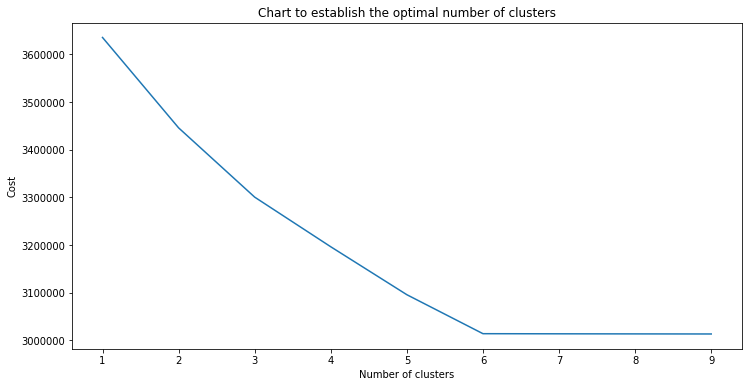

In [59]:
#Determine number of clusters using elbow method - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
cost = []
for k in range(1,10):
    kmodes = KModes(n_clusters=k, init = "Cao")
    kmodes.fit(c_3_components)
    cost.append(kmodes.cost_)
    
plt.figure(figsize=(12,6))    
plt.plot(range(1,10), cost)
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.title("Chart to establish the optimal number of clusters")
plt.show()
# 5 clusters looks optimal

In [38]:
# Apply kmodes with 5 clusters and Cao method
kmodes_final = KModes(n_clusters=6, random_state=20, verbose=1, init = "Cao")
c_3['clusters'] = kmodes_final.fit_predict(c_3_components)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3013780.0


In [22]:
# Apply PCA to reduce data down to 2 dimensions
pca_2d = PCA(n_components=2)
twodim_pca = pca_2d.fit_transform(c_3_components)

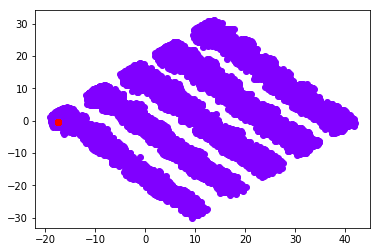

In [23]:
# Plot clusters in two dimensions - with PCA reduction
color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

for group in list(c_3['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_pca[c_3['clusters'] == group, 0], 
                twodim_pca[c_3['clusters'] == group, 1],
                color=c,
                label=group)

In [61]:
# Apply TSNE to reduce data down to 2 dimensions
tsne = TSNE(n_components=2, random_state=1986)
twodim_arr = tsne.fit_transform(c_3_components)

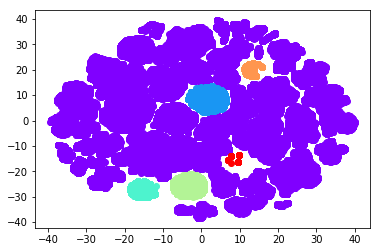

In [69]:
# Plot clusters in two dimensions - with TSNE reduction
color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

for group in list(c_3['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr[c_3['clusters'] == group, 0], 
                twodim_arr[c_3['clusters'] == group, 1],
                color=c,
                label=group)

In [63]:
# Apply TSNE to reduce data down to 3 dimensions
tsne = TSNE(n_components=3, random_state=1986)
threedim_arr = tsne.fit_transform(c_3_components)

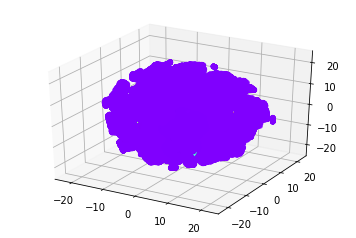

In [70]:
# Plot clusters in three dimensions
color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for group in list(c_3['clusters'].unique().tolist()):
    c = next(color)
    ax.scatter(threedim_arr[c_3['clusters'] == group, 0], 
               threedim_arr[c_3['clusters'] == group, 1],
               threedim_arr[c_3['clusters'] == group, 2],
               color=c,
               label=group)

In [71]:
# Apply kmodes with 20 clusters and Cao method
kmodes_20 = KModes(n_clusters=20, random_state=20, verbose=1, init = "Cao")
c_3['clusters_20'] = kmodes_20.fit_predict(c_3_components)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3011740.0


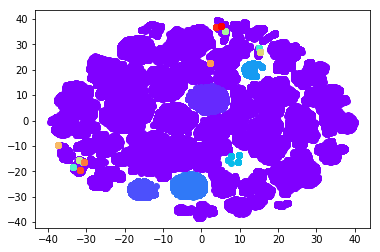

In [73]:
# Plot 20 clusters in two dimensions
color = iter(plt.cm.rainbow(np.linspace(0,1,20)))

for group in list(c_3['clusters_20'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr[c_3['clusters_20'] == group, 0], 
                twodim_arr[c_3['clusters_20'] == group, 1],
                color=c,
                label=group)

In [24]:
# Calculate Silhouette Score using https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
sil_avg = silhouette_score(c_3_components, c_3['clusters'])
sil_avg

0.10948968077421792

In [ ]:
# Avg Silhouette score is a little low, however higher than an attempt via kmeans
# Value of 1 indicates a datapoint is dissimilar from other clusters
# Value of 0 indicates the data point was 'borderline'
# Value -1 indicates a datapoint is dissimilar from other datapoints in cluster

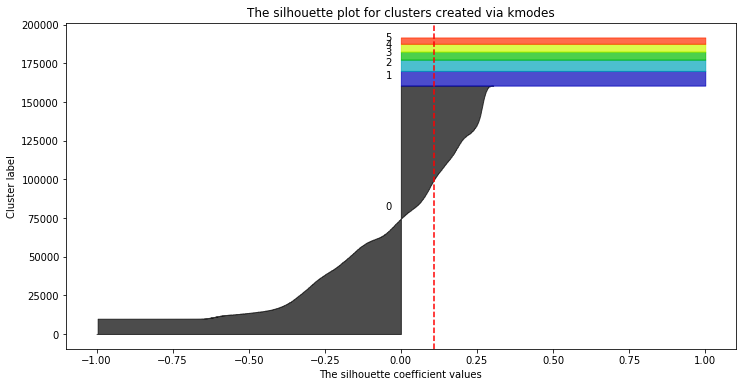

In [27]:
# Create a Silhouette plot from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# Compute the silhouette scores for each sample 
sample_silhouette_values = silhouette_samples(c_3_components, c_3['clusters'])


plt.figure(figsize=(12,6)) 
# Define where plot should start on y axis
y_lower = 10
for i in range(6):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[c_3['clusters'] == i]
    ith_cluster_silhouette_values.sort()
    
    # Establish size of cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Fill plot between y_lower and y_upper (defined by size of cluster) and the silouhette value for each datapoint
    color = plt.cm.nipy_spectral(float(i) / 6)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for clusters created via kmodes")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=sil_avg, color="red", linestyle="--")

### Explore segments

In [39]:
# Applying clustering to azdias dataset
az_3 = azdias_clean_copy

az_3_components = pca_3.transform(az_3)
az_3['clusters'] = kmodes_final.predict(az_3_components)

Text(0.5,1,'Distribution of customer and general population data across clusters')

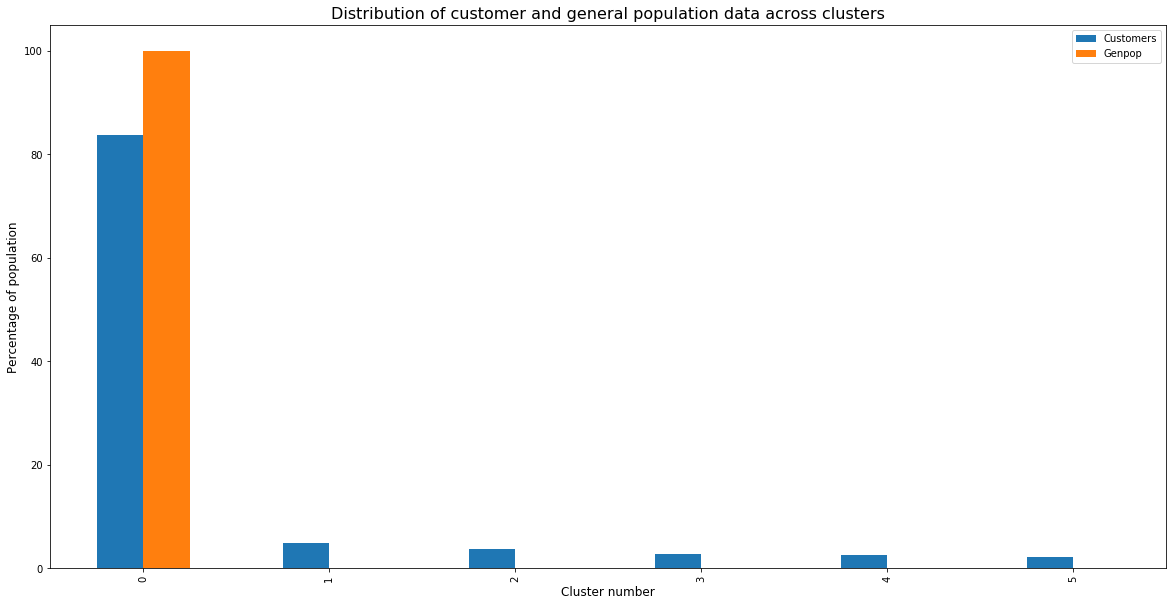

In [40]:
# Calculate distribution of customer and genpop individuals across clusters
customer_perc = c_3['clusters'].value_counts()/c_3['clusters'].shape[0]*100
gen_pop_perc = az_3['clusters'].value_counts()/az_3['clusters'].shape[0]*100
distributions = {'Customers': customer_perc, 'Genpop': gen_pop_perc}
dists = pd.DataFrame(data=distributions)

# Visualise distributions
dists.plot(kind = 'bar', figsize=(20,10))
plt.ylabel("Percentage of population", fontdict={'fontsize': 12})
plt.xlabel("Cluster number", fontdict={'fontsize': 12})
plt.title("Distribution of customer and general population data across clusters", fontdict={'fontsize': 16})

Chart shows that cluster 0 represents the general population (and most of the Arvato database) but that the additional 5 isolated clusters are not clearly identifiable in the general population. 
Therefore, individuals with characteristics described by these 5 clusters were more likely to be Arvato bank customers.

In [122]:
# Find mode category for clusters 1-5 for customers dataset and cluster 0 for gen pop dataset
cust_avg = c_3[c_3['clusters'].isin([1, 2, 3, 4, 5])].iloc[:,:-1].mode().rename(index={0: 'Customers'})
genpop_avg = az_3[az_3['clusters'].isin([0])].iloc[:,:-1].mode().rename(index={0: 'Genpop'})

In [123]:
# Combine scores
customer_scores = pd.concat([cust_avg, genpop_avg], axis=0).transpose()
customer_scores.head()

,Customers,Genpop
ALTER_HH,10.0,18.0
ARBEIT,3.0,4.0
BALLRAUM,6.0,6.0
CAMEO_DEUG_2015,2.0,8.0
CAMEO_INTL_2015,14.0,51.0


Text(0.5,1,'Chart to demonstrate the features which differ most between Customer and General Population')

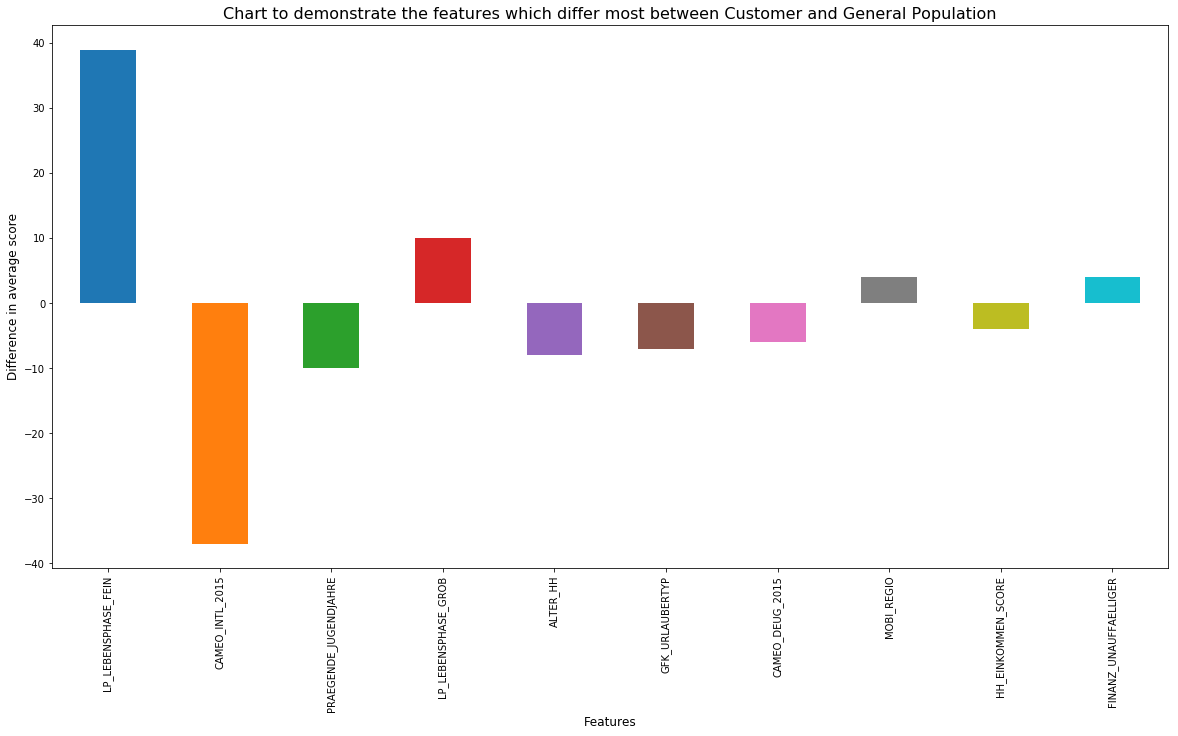

In [124]:
# Calcuate difference between customer score and gen pop score
customer_scores['Difference'] = customer_scores['Customers'] - customer_scores['Genpop']
customer_scores['Absolute_Difference'] = abs(customer_scores['Customers'] - customer_scores['Genpop'])
customer_scores.sort_values(by = 'Absolute_Difference',ascending = False)['Difference'].head(10).plot(kind = 'bar', figsize=(20,10))
plt.ylabel("Difference in average score", fontdict={'fontsize': 12})
plt.xlabel("Features", fontdict={'fontsize': 12})
plt.title("Chart to demonstrate the features which differ most between Customer and General Population", fontdict={'fontsize': 16})

In [125]:
# Create list of features which differ most
features = customer_scores.sort_values(by = 'Absolute_Difference',ascending = False)['Difference'].head(10).index

In [126]:
# Summary of differing features
customer_scores.loc[features]

,Customers,Genpop,Difference,Absolute_Difference
LP_LEBENSPHASE_FEIN,40.0,1.0,39.0,39.0
CAMEO_INTL_2015,14.0,51.0,-37.0,37.0
PRAEGENDE_JUGENDJAHRE,4.0,14.0,-10.0,10.0
LP_LEBENSPHASE_GROB,12.0,2.0,10.0,10.0
ALTER_HH,10.0,18.0,-8.0,8.0
GFK_URLAUBERTYP,5.0,12.0,-7.0,7.0
CAMEO_DEUG_2015,2.0,8.0,-6.0,6.0
MOBI_REGIO,5.0,1.0,4.0,4.0
HH_EINKOMMEN_SCORE,2.0,6.0,-4.0,4.0
FINANZ_UNAUFFAELLIGER,5.0,1.0,4.0,4.0


LP_LEBENSPHASE_FEIN - 
- The most common category for Arvato customes: top earners at retirement age from mulitperson households
- The most common category for the general population: single low-income earners of younger age

CAMEO_INTL_2015
- The most common category for Arvato customes: Wealthy Households-Older Families &  Mature Couples
- The most common category for the general population: Poorer Households-Pre-Family Couples & Singles

PRAEGENDE_JUGENDJAHRE
- The most common category for Arvato customes: 50ies - milk bar / Individualisation (Avantgarde, O+W)
- The most common category for the general population: 90ies - digital media kids (Mainstream, O+W)

LP_LEBENSPHASE_GROB
- The most common category for Arvato customes: high-income earners of higher age from multiperson households
- The most common category for the general population: single low-income- and average earners of higher age 

ALTER_HH
- The most common category for Arvato customes: main age within the household between 01.01.1940 bis 31.12.1944
- The most common category for the general population: main age within the household between 01.01.1980 bis 31.12.1984

GFK_URLAUBERTYP
- The most common category for Arvato customes: Nature fans
- The most common category for the general population: without vacation

CAMEO_DEUG_2015
- The most common category for Arvato customes: upper middleclass
- The most common category for the general population: working class

MOBI_REGIO
- The most common category for Arvato customes: very low mobility 
- The most common category for the general population: very high mobility

HH_EINKOMMEN_SCORE
- The most common category for Arvato customes: very high income
- The most common category for the general population: very low income

FINANZ_UNAUFFAELLIGER
- The most common category for Arvato customes: financial typology: unremarkable - very low
- The most common category for the general population: financial typology: unremarkable - very high

In conclusion, Arvato customers are generally older, perhaps retired, top earners and of an upper class.

In [132]:
# Subset customer data to features which differ most between customers and genpop
c3_subset = c_3[features]
c3_subset['clusters'] = c_3['clusters']
c3_subset.head()

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,LP_LEBENSPHASE_FEIN,CAMEO_INTL_2015,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_GROB,ALTER_HH,GFK_URLAUBERTYP,CAMEO_DEUG_2015,MOBI_REGIO,HH_EINKOMMEN_SCORE,FINANZ_UNAUFFAELLIGER,clusters
0,20.0,13.0,4.0,5.0,10.0,4.0,1.0,4.0,1.0,2.0,0
1,40.0,14.0,4.0,12.0,11.0,5.0,2.0,5.0,2.0,3.0,0
2,13.0,34.0,4.0,3.0,6.0,3.0,5.0,3.0,1.0,4.0,0
3,40.0,24.0,1.0,12.0,8.0,10.0,4.0,4.0,4.0,1.0,0
4,31.0,41.0,8.0,10.0,20.0,2.0,7.0,3.0,6.0,5.0,0


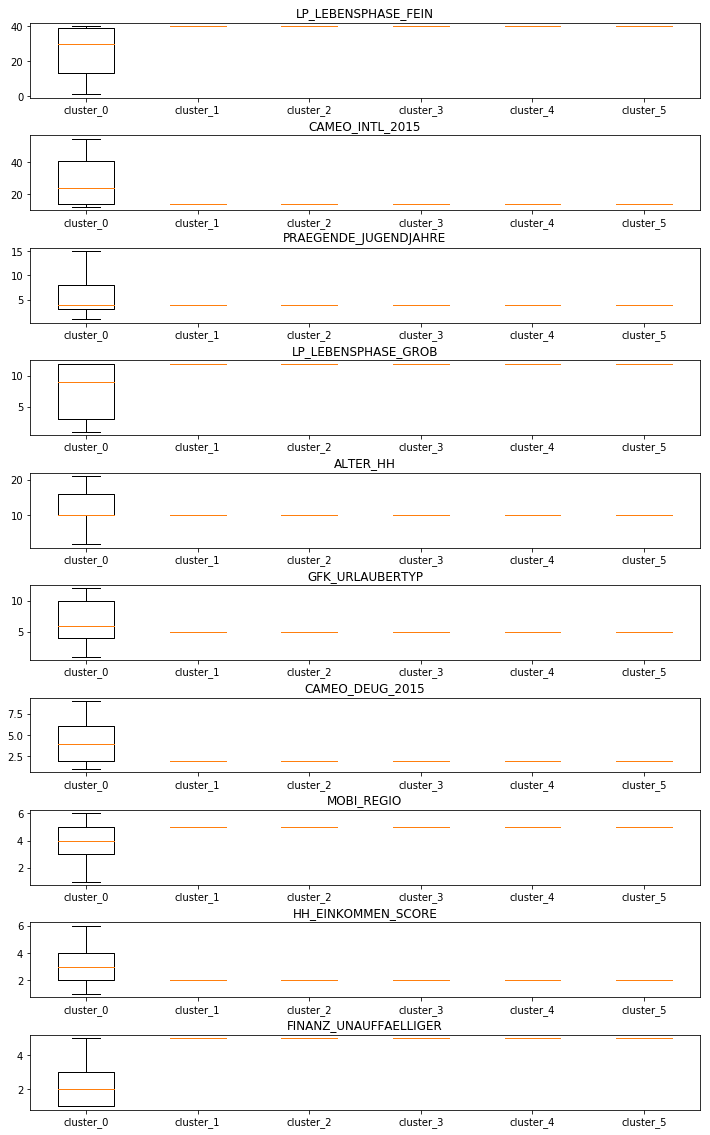

In [134]:
# Plot the distribution for the top 10 features for each cluster
fig, axes = plt.subplots(10, 1)
fig.subplots_adjust(hspace=0.5)
fig.set_figheight(20)
fig.set_figwidth(12) 

for i, kpi in enumerate(c3_subset.iloc[:,:-1].columns.tolist()):
    axes[i].set_title(kpi)
    data = list()
    for j in range(6):
        data.append(c3_subset[c3_subset['clusters'] == j][kpi])
    axes[i].boxplot(data, labels=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3','cluster_4', 'cluster_5'])

### Appendix: Kmeans

In [53]:
#Import data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

# Apply function to datasets
c_4, fs = clean_data(customers, feature_summary)
az_4, fs = clean_data(azdias, feature_summary)

# One hot encode categorical, non ordinal data
categorical_cols = list(fs[(fs['type'] == 'categorical')|(fs['type'] == 'mixed')]['attribute'])
categorical_cols.append('CAMEO_DEU_2015_let')
c_4 = pd.get_dummies(data=c_4, columns=categorical_cols)
az_4 = pd.get_dummies(data=az_4, columns=categorical_cols)

# Remove columns which aren't present in both dataframes ahead of segmentation
uncommon_cols = set(c_4.columns).symmetric_difference(set(az_4.columns))
c_4 = c_4.drop(columns = uncommon_cols, axis=1, errors = 'ignore')
az_4 = az_4.drop(columns = uncommon_cols, axis=1, errors = 'ignore')

# Remove ID column named LNR
c_4 = c_4.drop(columns = ['LNR'], axis=1)
az_4 = az_4.drop(columns = ['LNR'], axis=1)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


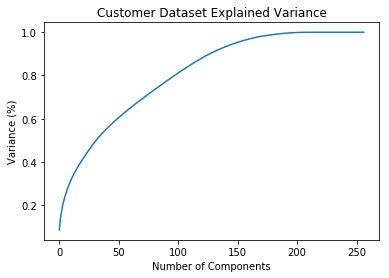

In [54]:
# Declare and fit scaler to customers dataset - as kmeans looks at Euclidean distance, all fields must be on same scale
scaler_4 = StandardScaler()
scaler_4.fit(c_4)
c_4_scaled_features = scaler_4.transform(c_4)
c_4_scaled = pd.DataFrame(c_4_scaled_features, columns=c_4.columns)

# Reduce data
# Determine the number of components to use using link: https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
# Fitting the PCA algorithm with our Data
pca_4 = PCA().fit(c_4_scaled)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_4.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Customer Dataset Explained Variance')
plt.show()
# Plot suggests 125 components descripe 90% of the data

In [55]:
# Reduce customers dataset to 125 components using PCA
pca_4 = PCA(n_components=150)
c_4_components = pca_4.fit_transform(c_4_scaled)

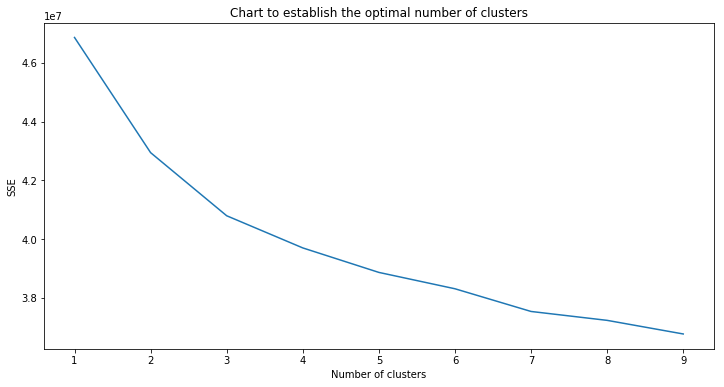

In [56]:
# Determine number of clusters using elbow method - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
sse = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(c_4_components)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))    
plt.plot(range(1,10), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Chart to establish the optimal number of clusters")
plt.show()
# 4 clusters looks optimal

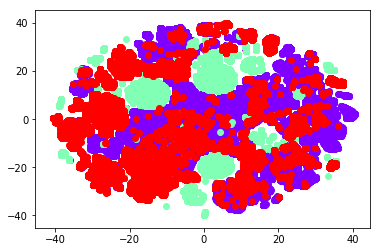

In [57]:
# Apply kmeans to scaled, reduced data and create column of results
kmeans = KMeans(n_clusters=3, random_state=20)
c_4_components = pd.DataFrame(c_4_components)
c_4_components['clusters'] = kmeans.fit_predict(c_4_components)

# Reduce customers dataset to 50 components using PCA to speed up TSNE
pca_5 = PCA(n_components=50)
c_5_components = pca_5.fit_transform(c_4_components)

# Apply TSNE to reduce down to 2 dimensions
tsne_5 = TSNE(n_components=2, random_state=1986)
twodim_arr_5 = tsne_5.fit_transform(c_5_components)


# Plot clusters created via kmeans in two dimensions
color = iter(plt.cm.rainbow(np.linspace(0,1,3)))

for group in list(c_4_components['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr_5[c_4_components['clusters'] == group, 0], 
                twodim_arr_5[c_4_components['clusters'] == group, 1],
                color=c,
                label=group)

In [58]:
# Calculate Silhouette score of applying KMeans
sil_avg = silhouette_score(c_4_components, c_4_components['clusters'])
sil_avg

0.10600661698048469

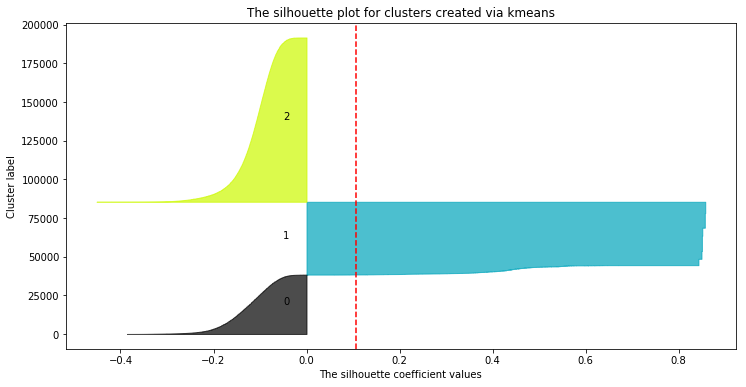

In [59]:
# Compute the silhouette scores for each sample from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


# Establish silhouette values = measure of similarity/distance between a data point and its assigned cluster
# Value of 1 indicates a datapoint is dissimilar from other clusters
# Value of 0 indicates the data point was 'borderline'
# Value -1 indicates a datapoint is dissimilar from other datapoints in cluster
sample_silhouette_values = silhouette_samples(c_4_components, c_4_components['clusters'])


plt.figure(figsize=(12,6)) 
# Define where plot should start on y axis
y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[c_4_components['clusters'] == i]
    ith_cluster_silhouette_values.sort()
    
    # Establish size of cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Fill plot between y_lower and y_upper (defined by size of cluster) and the silouhette value for each datapoint
    color = plt.cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for clusters created via kmeans")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=sil_avg, color="red", linestyle="--")


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
# Load training data
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';', dtype={18: object, 19: object})

In [5]:
# Apply cleaning function to cleaning data
train, feature_summary_updated = clean_data(mailout_train, feature_summary)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [6]:
# Label encode object fields
le = preprocessing.LabelEncoder()
obj_cols = train.columns[train.dtypes == 'object']
train[obj_cols] = train[obj_cols].apply(le.fit_transform)

In [7]:
# Assign target variable to Y
# Assign all columns minus target variable to X
y = train['RESPONSE']
x = train.drop(columns = ['RESPONSE'], axis = 1)

In [8]:
# Split into training and validation datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.3, random_state=101)

In [9]:
# Create list of categorical columns - as catboost and light GBM work best if these are specified
categorical_cols = list(feature_summary_updated[(feature_summary_updated['type'] == 'categorical')|(feature_summary_updated['type'] == 'mixed')]['attribute'])


In [36]:
# Define evaluation functions
def auc(model, x_train, x_test, y_train, y_test): 
    return (metrics.roc_auc_score(y_train, model.predict_proba(x_train)[:,1]),
                            metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))

def auc2(model, x_train, x_test, y_train, y_test): 
    return (metrics.roc_auc_score(y_train,model.predict(x_train)),
                            metrics.roc_auc_score(y_test,model.predict(x_test)))

def aucpr(model, x_train, x_test, y_train, y_test):
    return (metrics.average_precision_score(y_train, model.predict_proba(x_train)[:,1]),
                            metrics.average_precision_score(y_test, model.predict_proba(x_test)[:,1]))    

def aucpr2(model, x_train, x_test, y_train, y_test): 
    return (metrics.average_precision_score(y_train, model.predict(x_train)),
                            metrics.average_precision_score(y_test, model.predict(x_test)))

### Model comparisons - help from https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

### Light GBM

In [83]:
# Tune Light GBM model
lgbm_model = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [1, 2, 5],
              "learning_rate" : [0.05, 0.1, 0.5],
              "num_leaves": [10, 25, 50, 75],
              "n_estimators": [200]
             }
lgbm_grid_search = GridSearchCV(lgbm_model, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
lgbm_grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 5], 'learning_rate': [0.05, 0.1, 0.5], 'num_leaves': [10, 25, 50, 75], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [87]:
# Summary of grid search results
print("\n The best estimator across ALL searched params:\n",
lgbm_grid_search.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
lgbm_grid_search.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
lgbm_grid_search.best_params_)


 The best estimator across ALL searched params:
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.5, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=10, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 0.545572033358914

 The best parameters across ALL searched params:
 {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 200, 'num_leaves': 10}


In [11]:
# Fit tuned LightGBM model
d_train = lgb.Dataset(x_train, label=y_train)
params = {"max_depth": 1, 
          "learning_rate" : 0.5, 
          "num_leaves": 10,  
          "n_estimators": 200}
lgbm_model_tuned = lgb.train(params, d_train, categorical_feature = categorical_cols)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGER_TYP', 'ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'WOHNLAGE', 'ZABEOTYP']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [60]:
# Evaluate LightGBM model
auc = auc2(lgbm_model_tuned, x_train, x_test, y_train, y_test)
aucpr = aucpr2(lgbm_model_tuned, x_train, x_test, y_train, y_test)
model_performance = [("LightGBM AUC", auc), ("LightGBM AUCPR", aucpr)]
model_performance

### Catboost

In [38]:
# Tune Catboost model
params = {'depth': [5, 10, 15],
          'learning_rate' : [0.01, 0.03, 0.05],
          'l2_leaf_reg': [1,4,9],
          'iterations': [300]}

In [39]:
cb = CatBoostClassifier()

In [40]:
cb_grid_search = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)

In [41]:
cb_grid_search.fit(x_train, y_train, verbose = False)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x10ca8a7f0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'depth': [5, 10, 15], 'learning_rate': [0.01, 0.03, 0.05], 'l2_leaf_reg': [1, 4, 9], 'iterations': [300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
print("\n The best estimator across ALL searched params:\n",
cb_grid_search.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
cb_grid_search.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
cb_grid_search.best_params_)


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.571476372023781

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.03}


In [14]:
# Fit tuned Catboost model

#clf = CatBoostClassifier()

cb_model_tuned = CatBoostClassifier(depth = 10, 
                                    learning_rate = 0.03, 
                                    l2_leaf_reg = 4,  
                                    iterations = 300,
                                    eval_metric="AUC", 
                                    one_hot_max_size=31)
cb_model_tuned.fit(x_train, y_train, cat_features= categorical_cols, verbose = False)

In [17]:
# Evaluate Catboost model
cb_auc = auc(cb_model_tuned, x_train, x_test, y_train, y_test)
cb_aucpr = aucpr(cb_model_tuned, x_train, x_test, y_train, y_test)
model_performance.append(("Catboost AUC", cb_auc))
model_performance.append(("Catboost AUCPR", cb_aucpr))

#model_performance = [("Catboost AUC", cb_auc), ("Catboost AUCPR", cb_aucpr)]
model_performance

[('LightGBM AUC', (0.7439297629152931, 0.537147499785302)),
 ('LightGBM AUCPR', (0.04930788829055523, 0.014471576498594046)),
 ('Catboost AUC', (0.9458956455037945, 0.5738224379748781)),
 ('Catboost AUCPR', (0.7259177436092481, 0.017759533447865673))]

### XGBoost 

In [19]:
# One hot encode categorical fields for XGBoost model
categorical_cols = list(feature_summary_updated[(feature_summary_updated['type'] == 'categorical')|(feature_summary_updated['type'] == 'mixed')]['attribute'])
categorical_cols.append('CAMEO_DEU_2015_let')
xgb_train = pd.get_dummies(data=x_train, columns=categorical_cols)
xgb_test = pd.get_dummies(data=x_test, columns=categorical_cols)

In [78]:
xgb_train.head()

,LNR,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,...,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,CAMEO_DEU_2015_let_0,CAMEO_DEU_2015_let_1,CAMEO_DEU_2015_let_2,CAMEO_DEU_2015_let_3,CAMEO_DEU_2015_let_4,CAMEO_DEU_2015_let_5
9540,47281,14.0,2.000000,0.000000,1.0,0.0,3.0,7.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
34593,79480,13.0,6.808657,0.049574,1.0,0.0,4.0,6.0,6.0,2.0,...,0,0,0,0,0,1,0,0,0,0
24990,54351,19.0,2.000000,0.000000,4.0,0.0,3.0,3.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,1
12421,7604,7.0,4.000000,0.000000,0.0,0.0,4.0,1.0,6.0,1.0,...,0,0,0,1,0,1,0,0,0,0
7338,69358,9.0,3.000000,0.000000,1.0,0.0,1.0,2.0,3.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [84]:
# Tune XGBoost model
xgb_model = xgb.XGBClassifier()
param_dist = {"max_depth": [2, 5, 10, 15],
              "min_child_weight" : [3, 6, 9],
              "n_estimators": [200],
              "learning_rate": [0.025, 0.05, 0.1],
             # "subsample": [0.7, 0.8, 0.9],
             # "colsample_bytree": [0.7, 0.8, 0.9],
             # "gamma": [0, 0.1],
             # "reg_alpha": [0, 0.005]
             }
xgb_grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1, scoring="roc_auc")
xgb_grid_search.fit(xgb_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", Use

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 5, 10, 15], 'min_child_weight': [3, 6, 9], 'n_estimators': [200], 'learning_rate': [0.025, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [88]:
# Summary of grid search results
print("\n The best estimator across ALL searched params:\n",
xgb_grid_search.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
xgb_grid_search.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
xgb_grid_search.best_params_)


 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=9, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 The best score across ALL searched params:
 0.5547764486387292

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 200}


In [20]:
# Fit tuned XGBoost model
xgb_model_tuned = xgb.XGBClassifier(max_depth=5, 
                                    min_child_weight=9, 
                                    n_estimators=200, 
                                    n_jobs=1 , 
                                    verbose=1,
                                    learning_rate=0.05)
xgb_model_tuned.fit(xgb_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=9, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [21]:
# Evaluate XGBoost model
xgb_auc = auc(xgb_model_tuned, xgb_train, xgb_test, y_train, y_test)
xgb_aucpr = aucpr(xgb_model_tuned, xgb_train, xgb_test, y_train, y_test)
model_performance.append(("XGBoost AUC", xgb_auc))
model_performance.append(("XGBoost AUCPR", xgb_aucpr))
model_performance

[('LightGBM AUC', (0.7439297629152931, 0.537147499785302)),
 ('LightGBM AUCPR', (0.04930788829055523, 0.014471576498594046)),
 ('Catboost AUC', (0.9458956455037945, 0.5738224379748781)),
 ('Catboost AUCPR', (0.7259177436092481, 0.017759533447865673)),
 ('XGBoost AUC', (0.9019802180303196, 0.5547290059256648)),
 ('XGBoost AUCPR', (0.2876936472022296, 0.015157300291978334))]

Best peforming model according to AUC of the ROC curve and Precision recall curves is Catboost.

### Final model evaluation

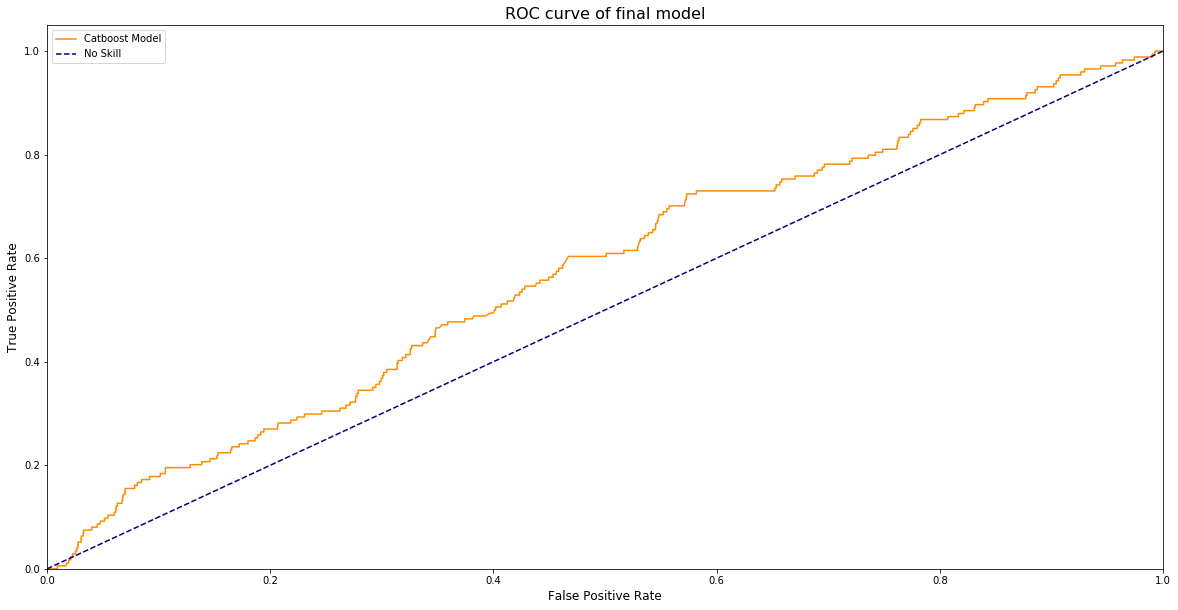

In [58]:
# Plot ROC curve using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html and https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
# Calcuate true and false positive rates and plot
plt.figure(figsize=(20,10))
false_pos, true_pos, _ = roc_curve(y_test, cb_model_tuned.predict_proba(x_test)[:,1])
plt.plot(false_pos, true_pos, color='darkorange', label='Catboost Model')

# Plot ROC curve of random classifier
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')

# Format chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
plt.title('ROC curve of final model', fontdict={'fontsize': 16})
plt.legend()

plt.show()

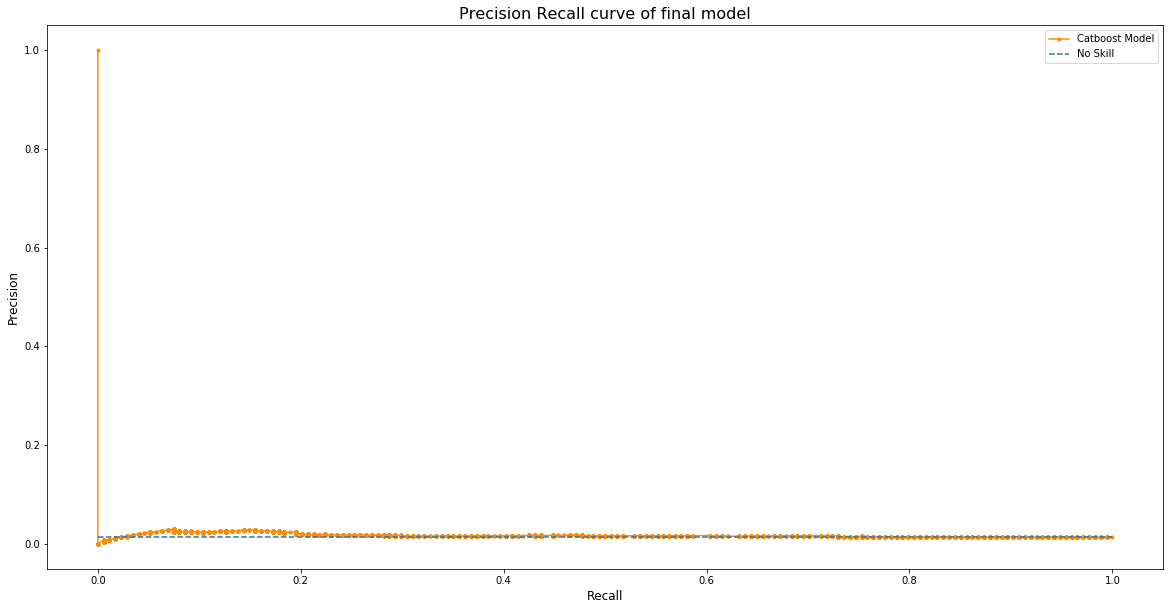

In [59]:
# Plot Precision Recall Curve using https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
# Calcuate precision and recall of model andplot
plt.figure(figsize=(20,10))
precision, recall, _ = precision_recall_curve(y_test, cb_model_tuned.predict_proba(x_test)[:,1])
plt.plot(recall, precision, color='darkorange', marker='.', label='Catboost Model')

# Plot Precision recall curve of random classifier
no_skill = len(y_test[y_test ==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# Format chart
plt.xlabel('Recall', fontdict={'fontsize': 12})
plt.ylabel('Precision', fontdict={'fontsize': 12})
plt.title('Precision Recall curve of final model', fontdict={'fontsize': 16})
plt.legend()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [72]:
# Import test data
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';', dtype={18: object, 19: object})

In [73]:
# Apply cleaning function
test, feature_summary_updated = clean_data(mailout_test, feature_summary)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [74]:
# Label encode object fields
le = preprocessing.LabelEncoder()
test[obj_cols] = test[obj_cols].apply(le.fit_transform)

In [75]:
# One hot encode categorical for xgboost
categorical_cols = list(feature_summary_updated[(feature_summary_updated['type'] == 'categorical')|(feature_summary_updated['type'] == 'mixed')]['attribute'])
categorical_cols.append('CAMEO_DEU_2015_let')

In [76]:
# Glimpse at test data
test.head()

,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_let
0,1754,2.0,7.0,2.0,0.0,2.0,0.0,3.0,6.0,2.0,...,3.0,0.0,1.0,6.0,9.0,3.0,3.0,1.0,4.0,1
1,1770,2.0,9.0,20.0,0.0,1.0,0.0,4.0,7.0,5.0,...,2.0,0.0,1.0,6.0,9.0,5.0,3.0,1.0,4.0,0
2,1465,2.0,16.0,2.0,0.0,4.0,0.0,4.0,1.0,7.0,...,3.0,0.0,1.0,2.0,9.0,4.0,3.0,2.0,4.0,0
3,1470,2.0,9.0,1.0,0.0,0.0,0.0,4.0,1.0,2.0,...,3.0,0.0,2.0,6.0,9.0,2.0,3.0,2.0,4.0,1
4,1478,1.0,21.0,1.0,0.0,4.0,0.0,3.0,6.0,5.0,...,3.0,0.0,1.0,3.0,9.0,7.0,4.0,2.0,4.0,0


In [77]:
# Use model to predict responses on testdata
test['RESPONSE'] = cb_model_tuned.predict_proba(test)[:,1]

In [78]:
# Filter to ID and prediction columns
kaggle_data = test[['LNR', 'RESPONSE']]

In [79]:
# View data
kaggle_data.head()

,LNR,RESPONSE
0,1754,0.016014
1,1770,0.009270
2,1465,0.008636
3,1470,0.005372
4,1478,0.007276


In [80]:
# Save data for uploading to Kaggle
kaggle_data.to_csv('data/kaggle_submission_8.csv', index=False)